In [25]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib

In [26]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0
# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])
model.summary()
# Train the digit classification model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=1,
  validation_data=(test_images, test_labels)
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 12)        120       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 12)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2028)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                20290     
Total params: 20,410
Trainable params: 20,410
Non-trainable params: 0
_________________________________________________________________
1875/1875 [==============================] - 15s 8ms/step - loss: 0.2781 - accuracy: 0.9219 - val_loss: 0.1329 - val

In [27]:
# 转换为TensorFlow Lite模型
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp44z70dc_/assets
INFO:tensorflow:Assets written to: /tmp/tmp44z70dc_/assets


In [28]:
# 保存TensorFlow Lite模型
tflite_models_dir = pathlib.Path("./mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)

84528

In [29]:
# 对导出模型进行量化
converter.optimizations = [tf.lite.Optimize.DEFAULT] # 设置为针对大小进行优化
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpcn0nap1y/assets
INFO:tensorflow:Assets written to: /tmp/tmpcn0nap1y/assets


23904

In [30]:
ls -lh {tflite_models_dir}

总用量 108K
-rw-rw-r-- 1 ace ace 24K 1月  12 15:42 mnist_model_quant.tflite
-rw-rw-r-- 1 ace ace 83K 1月  12 15:42 mnist_model.tflite


In [31]:
# 使用Python TensorFlow Lite解释器运行TensorFlow Lite模型。
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file)) # 加载模型
interpreter.allocate_tensors()

In [32]:
# 加载量化后的模型
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

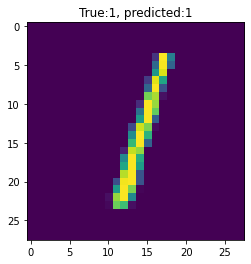

In [44]:
# 测试
num = 2
test_image = np.expand_dims(test_images[num], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

import matplotlib.pylab as plt
plt.imshow(test_images[num])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(test_labels[num]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

In [35]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

In [36]:
print(evaluate_model(interpreter))

0.9625


In [37]:
# 对动态范围量化模型重复评估
print(evaluate_model(interpreter_quant))

0.9628
